## Comparing Wind Power ##

we have two wind power datasets:

1. Obs data from ERA5 conversion
2. Model data (first NDJFMAMJJASO) from HadGEM3-GC31-MM conversion

We want to compare the model demand data to the obs demand data to see how similar/different these are and visually assess whether we are getting similar(-ish) values. 

In [23]:
# cell magic
%load_ext autoreload
%autoreload 2
%matplotlib inline

# Load local modules
import os
import sys
import glob
import importlib

# Import external modules
import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt

# tqdm for progress bars
from tqdm import tqdm

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [24]:
# Set up the global variables
dfs_dir = "/gws/nopw/j04/canari/users/benhutch/met_to_energy_dfs"

# model filename
model_wind_ons = "United_Kingdom_wind_power_df_test_ons_1960_2018_NDJFM.csv"
model_wind_ofs = "United_Kingdom_wind_power_df_test_ofs_1960_2018_NDJFM.csv"

# obs filename
obs_wind_ons = "United_Kingdom_obs_wind_speed_cfs_ons.csv"
obs_wind_ofs = "United_Kingdom_obs_wind_speed_cfs_ofs.csv"

In [25]:
# Set up the values of installed capacities in 2023
# Make some assumptions about the power system
# wind power capacity factors - includes both onshore and offshore?
# also I guess power system is 2021 ish set up?
# although won't have changed significantly since then
# Not sure how accurate these are leached from:
# https://windeurope.org/intelligence-platform/product/wind-energy-in-europe-2023-statistics-and-the-outlook-for-2024-2030/
installed_ofs_2023 = 14.756  # GW
installed_ons_2023 = 14.866  # GW

In [26]:
# Load the data
model_wind_ons_df = pd.read_csv(os.path.join(dfs_dir, model_wind_ons))
model_wind_ofs_df = pd.read_csv(os.path.join(dfs_dir, model_wind_ofs))

obs_wind_ons_df = pd.read_csv(os.path.join(dfs_dir, obs_wind_ons))
obs_wind_ofs_df = pd.read_csv(os.path.join(dfs_dir, obs_wind_ofs))

In [27]:
model_wind_ons_df.head()

,init,lead,member,United_Kingdom_wind_power_cfs_ons
0,1960,1,1,0.682444
1,1960,1,2,0.681283
2,1960,1,3,0.684550
3,1960,1,4,0.687110
4,1960,1,5,0.685891


In [28]:
model_wind_ofs_df.head()

,init,lead,member,United_Kingdom_wind_power_cfs_ofs
0,1960,1,1,0.800509
1,1960,1,2,0.800961
2,1960,1,3,0.800905
3,1960,1,4,0.803976
4,1960,1,5,0.802065


In [29]:
obs_wind_ons_df.head()

,time,obs_wind_speed_100m_bc,obs_cfs_ons
0,1960-11-01,11.325152,0.699079
1,1960-11-02,14.248714,0.804985
2,1960-11-03,10.112684,0.553986
3,1960-11-04,8.534932,0.419052
4,1960-11-05,7.439478,0.249140


In [30]:
obs_wind_ofs_df.head()

,time,obs_wind_speed_100m_bc,obs_cfs_ofs
0,1960-11-01,11.325152,0.826896
1,1960-11-02,14.248714,0.874877
2,1960-11-03,10.112684,0.661860
3,1960-11-04,8.534932,0.496145
4,1960-11-05,7.439478,0.326865


In [31]:
# Combine the two model dataframes
model_wind_df = pd.concat([model_wind_ons_df, model_wind_ofs_df], axis=1)

In [32]:
# remove duplicate columns
model_wind_df = model_wind_df.loc[:, ~model_wind_df.columns.duplicated()]

In [33]:
model_wind_df.head()

,init,lead,member,United_Kingdom_wind_power_cfs_ons,United_Kingdom_wind_power_cfs_ofs
0,1960,1,1,0.682444,0.800509
1,1960,1,2,0.681283,0.800961
2,1960,1,3,0.684550,0.800905
3,1960,1,4,0.687110,0.803976
4,1960,1,5,0.685891,0.802065


In [34]:
# Combine the two obs dataframes
obs_wind_df = pd.concat([obs_wind_ons_df, obs_wind_ofs_df], axis=1)

In [35]:
# remove duplicate columns
obs_wind_df = obs_wind_df.loc[:, ~obs_wind_df.columns.duplicated()]

In [36]:
# ensure that time is datetime
obs_wind_df["time"] = pd.to_datetime(obs_wind_df["time"])

# set time as the index
obs_wind_df.set_index("time", inplace=True)

# remove the name of the index
obs_wind_df.index.name = None

In [37]:
obs_wind_df.head()

,obs_wind_speed_100m_bc,obs_cfs_ons,obs_cfs_ofs
1960-11-01,11.325152,0.699079,0.826896
1960-11-02,14.248714,0.804985,0.874877
1960-11-03,10.112684,0.553986,0.661860
1960-11-04,8.534932,0.419052,0.496145
1960-11-05,7.439478,0.249140,0.326865


In [38]:
model_wind_df.head()

,init,lead,member,United_Kingdom_wind_power_cfs_ons,United_Kingdom_wind_power_cfs_ofs
0,1960,1,1,0.682444,0.800509
1,1960,1,2,0.681283,0.800961
2,1960,1,3,0.684550,0.800905
3,1960,1,4,0.687110,0.803976
4,1960,1,5,0.685891,0.802065


In [39]:
# compute the onshore wind power and offshore wind power
model_wind_df["ons_gen"] = model_wind_df["United_Kingdom_wind_power_cfs_ons"] * installed_ons_2023
model_wind_df["ofs_gen"] = model_wind_df["United_Kingdom_wind_power_cfs_ofs"] * installed_ofs_2023

obs_wind_df["ons_gen"] = obs_wind_df["obs_cfs_ons"] * installed_ons_2023
obs_wind_df["ofs_gen"] = obs_wind_df["obs_cfs_ofs"] * installed_ofs_2023

In [40]:
# constrain the obs wind df to NDJFM
obs_wind_df_NDJFM = obs_wind_df.loc[obs_wind_df.index.month.isin([11, 12, 1, 2, 3])]

# shift back by 3 months and take the annual mean
obs_wind_df_NDJFM = obs_wind_df_NDJFM.shift(-3).resample("Y").mean()

In [43]:
#  set the index to just be years
obs_wind_df_NDJFM.index = obs_wind_df_NDJFM.index.year

In [44]:
obs_wind_df_NDJFM.head()

,obs_wind_speed_100m_bc,obs_cfs_ons,obs_cfs_ofs,ons_gen,ofs_gen
1960,7.615372,0.317502,0.386287,4.719981,5.700048
1961,7.769681,0.332331,0.406113,4.940427,5.992599
1962,8.186395,0.368682,0.445239,5.480823,6.569943
1963,7.548107,0.308328,0.376753,4.583609,5.559361
1964,7.541095,0.310456,0.378537,4.615244,5.585694


In [45]:
model_wind_df.head()

,init,lead,member,United_Kingdom_wind_power_cfs_ons,United_Kingdom_wind_power_cfs_ofs,ons_gen,ofs_gen
0,1960,1,1,0.682444,0.800509,10.145220,11.812308
1,1960,1,2,0.681283,0.800961,10.127953,11.818976
2,1960,1,3,0.684550,0.800905,10.176522,11.818150
3,1960,1,4,0.687110,0.803976,10.214581,11.863471
4,1960,1,5,0.685891,0.802065,10.196456,11.835265


In [47]:
# do the same for the model data
model_wind_df_NDJFM = pd.DataFrame()

# loop over the unique inits in the model data
for init in model_wind_df["init"].unique():
    # constrain to the current init
    model_wind_init = model_wind_df.loc[model_wind_df["init"] == init]
    # loop over the unique members in the model data
    for member in model_wind_init["member"].unique():
        # constrain to the current member
        model_wind_member = model_wind_init.loc[model_wind_init["member"] == member]

        # Take the mean over leads 1-150
        model_wind_member_mean = model_wind_member[model_wind_member["lead"].isin(range(1, 151))].groupby(["init", "member"]).mean()

        # add the mean to the model_demand_NDJFM dataframe
        model_wind_df_NDJFM = pd.concat([model_wind_df_NDJFM, model_wind_member_mean])

# reset the index
model_wind_df_NDJFM.reset_index(inplace=True)

# convert init to datetime format
model_wind_df_NDJFM["init"] = pd.to_datetime(model_wind_df_NDJFM["init"], format="%Y")

# set the index to be the init
model_wind_df_NDJFM.set_index("init", inplace=True)

# remove the name of the index
model_wind_df_NDJFM.index.name = None

# remove the lead column
model_wind_df_NDJFM.drop(columns="lead", inplace=True)

In [52]:
model_wind_df_NDJFM

,member,United_Kingdom_wind_power_cfs_ons,United_Kingdom_wind_power_cfs_ofs,ons_gen,ofs_gen
1960,1,0.302699,0.366917,4.499927,5.414228
1960,2,0.268961,0.326913,3.998380,4.823929
1960,3,0.329829,0.397164,4.903244,5.860547
1960,4,0.269520,0.327850,4.006691,4.837756
1960,5,0.275900,0.332092,4.101528,4.900346
...,...,...,...,...,...
2018,6,0.304481,0.371643,4.526413,5.483965
2018,7,0.240862,0.295463,3.580652,4.359856
2018,8,0.236120,0.290004,3.510161,4.279304
2018,9,0.282167,0.343250,4.194696,5.065000


In [50]:
# format the idnex as %Y
model_wind_df_NDJFM.index = model_wind_df_NDJFM.index.strftime("%Y")

In [68]:
model_wind_df_NDJFM.head()

,member,United_Kingdom_wind_power_cfs_ons,United_Kingdom_wind_power_cfs_ofs,ons_gen,ofs_gen
1960,1,0.302699,0.366917,4.499927,5.414228
1960,2,0.268961,0.326913,3.998380,4.823929
1960,3,0.329829,0.397164,4.903244,5.860547
1960,4,0.269520,0.327850,4.006691,4.837756
1960,5,0.275900,0.332092,4.101528,4.900346


In [74]:
obs_wind_df_NDJFM.tail()

,obs_wind_speed_100m_bc,obs_cfs_ons,obs_cfs_ofs,ons_gen,ofs_gen
2015,9.384046,0.479497,0.567483,7.128205,8.373778
2016,7.902584,0.342007,0.413811,5.084275,6.106196
2017,8.054294,0.351632,0.430855,5.227360,6.357702
2018,8.238295,0.369569,0.450587,5.494008,6.648858
2019,8.165322,0.365757,0.442185,5.437338,6.524888


Text(0, 0.5, 'Onshore Wind Generation (GW)')

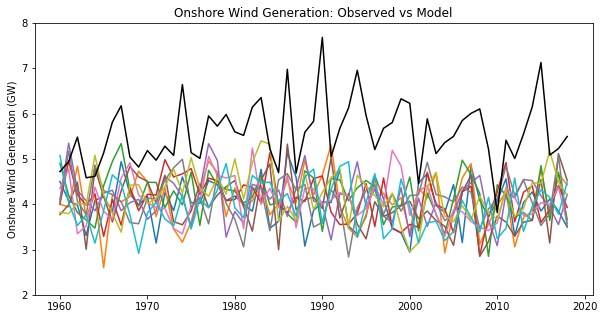

In [91]:
# set up the figure
fig, ax = plt.subplots(figsize=(10, 5))

# # # # # plot the observed data
# obs_wind_df_NDJFM["ons_gen"][:-1].plot(label="Observed", ax=ax, color="black")

# set up the index from obs
index = obs_wind_df_NDJFM["ons_gen"][:-1].index

# # print the min index of the obs data
# print(obs_wind_df_NDJFM["ons_gen"][:-1].index.min())
# print(obs_wind_df_NDJFM["ons_gen"][:-1].index.max())

# loop over the unique members
for member in model_wind_df_NDJFM["member"].unique():
    # plot the model data
    model_wind_df_NDJFM_member = model_wind_df_NDJFM.loc[model_wind_df_NDJFM["member"] == member]

    # extract the values
    values = model_wind_df_NDJFM_member["ons_gen"].values

    # # print the min index of the model data
    # print(model_wind_df_NDJFM_member.index.min())
    # print(model_wind_df_NDJFM_member.index.max())

    # plot the model data
    plt.plot(index, values, label=f"Model Member {member}")

# extract the observed values
obs_values = obs_wind_df_NDJFM["ons_gen"][:-1].values

# plot the observed data
plt.plot(index, obs_values, label="Observed", color="black")

# set constant ylims
ax.set_ylim(2, 8)

# set the title
plt.title("Onshore Wind Generation: Observed vs Model")

# set the ylabel
plt.ylabel("Onshore Wind Generation (GW)")


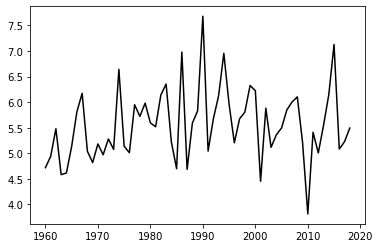

In [87]:
plt.plot(obs_wind_df_NDJFM["ons_gen"][:-1].index, obs_wind_df_NDJFM["ons_gen"][:-1], color="black", label="Observed")
# plt.plot(model_wind_df_NDJFM.index, model_wind_df_NDJFM["ons_gen"], color="blue", label="Model")

In [78]:
model_wind_df_NDJFM_member["ons_gen"]

1960    5.074840
1961    4.030969
1962    3.529285
1963    3.769505
1964    3.141721
1965    3.859272
1966    4.648751
1967    4.463926
1968    3.769014
1969    2.914474
1970    3.804104
1971    4.043195
1972    3.673842
1973    3.523559
1974    4.213163
1975    3.452666
1976    4.115779
1977    3.919505
1978    4.315065
1979    4.896411
1980    3.922020
1981    3.702424
1982    4.635720
1983    4.471995
1984    4.487474
1985    4.067733
1986    4.233627
1987    3.737155
1988    4.602245
1989    4.777130
1990    3.576425
1991    4.324472
1992    4.835345
1993    4.937389
1994    3.265090
1995    4.039668
1996    4.674384
1997    3.237771
1998    3.460312
1999    4.557399
2000    3.936089
2001    3.146606
2002    3.586984
2003    3.625721
2004    3.198502
2005    3.397421
2006    4.083545
2007    3.709282
2008    3.388035
2009    4.152065
2010    3.244437
2011    3.466994
2012    4.577195
2013    3.397491
2014    3.948849
2015    4.317932
2016    4.149269
2017    3.782355
2018    4.4863

In [73]:
# print the len of the obs data
print(len(obs_wind_df_NDJFM))

60
